In [2]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

d:\program\python3.8\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# GoodBooks-10K Data
df_books = pd.read_csv('books.csv', usecols=['book_id', 'title'])
df_ratings = pd.read_csv('ratings.csv', usecols=['user_id', 'book_id', 'rating'])

In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   book_id  10000 non-null  int64 
 1   title    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [5]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [6]:
df_books.head()

,book_id,title
0,1,"The Hunger Games (The Hunger Games, #1)"
1,2,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,"Twilight (Twilight, #1)"
3,4,To Kill a Mockingbird
4,5,The Great Gatsby


In [7]:
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [8]:
num_users = len(df_ratings.user_id.unique())
num_items = len(df_ratings.book_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 53424 unique users and 10000 unique movies in this data set


In [9]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1,124195
2,359257
3,1370916
4,2139018
5,1983093


In [11]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,528263521
1.0,124195
2.0,359257
3.0,1370916
4.0,2139018
5.0,1983093


In [12]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,528263521,20.085106
1.0,124195,11.729608
2.0,359257,12.791793
3.0,1370916,14.130990
4.0,2139018,14.575857
5.0,1983093,14.500168


Text(0, 0.5, 'number of ratings')

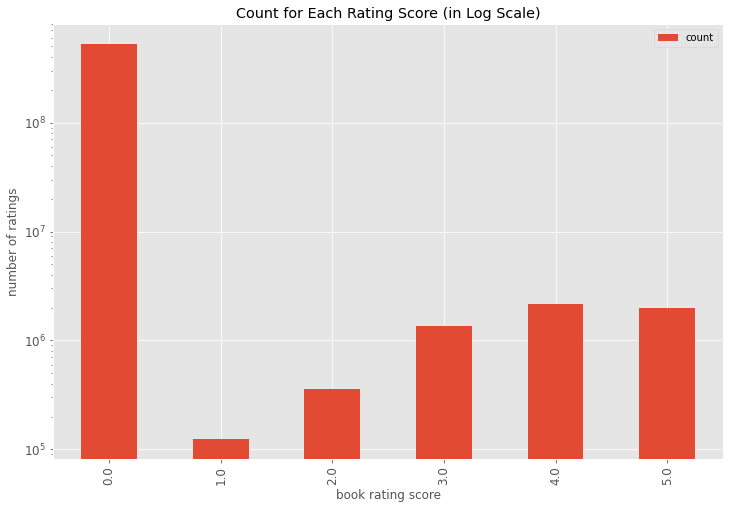

In [13]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("book rating score")
ax.set_ylabel("number of ratings")

In [14]:
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [16]:
# get rating frequency
df_books_cnt = pd.DataFrame(df_ratings.groupby('book_id').size(), columns=['count'])
df_books_cnt.head(3000)

,count
book_id,
1,22806
2,21850
3,16931
4,19088
5,16604
...,...
996,1334
997,1315
998,1307


In [ ]:
# plot rating frequency of all movies
ax = df_books_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Books',
        fontsize=12
    )
ax.set_xlabel("book id")
ax.set_ylabel("number of ratings")

In [ ]:
# plot rating frequency of all books in log scale
ax = df_books_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Books (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("book id")
ax.set_ylabel("number of ratings (log scale)")

In [ ]:
df_books_cnt['count'].quantile(np.arange(1, 0.6, -0.05))


In [ ]:
# filter data
popularity_thres = 100
popular_books = list(set(df_books_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_books = df_ratings[df_ratings.book_id.isin(popular_books)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular books: ', df_ratings_drop_books.shape)

In [ ]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_books.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

In [ ]:
# plot rating frequency of all books
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [20]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))


1.00    200.0
0.95    156.0
0.90    145.0
0.85    138.0
0.80    132.0
0.75    127.0
0.70    123.0
0.65    120.0
0.60    116.0
0.55    113.0
Name: count, dtype: float64

In [21]:
# filter data
ratings_thres = 100
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_books[df_ratings_drop_books.user_id.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (5976479, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (4537197, 3)


In [22]:
# pivot and create book-user matrix
book_user_mat = df_ratings_drop_users.pivot(index='book_id', columns='user_id', values='rating').fillna(0)
# create mapper from book title to index
book_to_idx = {
    book: i for i, book in 
    enumerate(list(df_books.set_index('book_id').loc[book_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
book_user_mat_sparse = csr_matrix(book_user_mat.values)

In [23]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(book_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [24]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [26]:
def make_recommendation(model_knn, data, mapper, fav_book, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    # model_knn.fit(data)
    # get input movie index
    print('You have input book:', fav_book)
    idx = fuzzy_matching(mapper, fav_book, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_book))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [30]:
my_favorite = 'Harry Potter'

make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_book=my_favorite,
    mapper=book_to_idx,
    n_recommendations=10)

You have input book: Harry Potter
Found possible matches in our database: ['Harry Potter: Film Wizardry', 'A Chair for My Mother', 'The Lottery', 'Dark Matter', 'Carry On']

Recommendation system start to make inference
......

Recommendations for Harry Potter:
1: New Moon: The Complete Illustrated Movie Companion (The Twilight Saga: The Official Illustrated Movie Companion, #2), with distance of 0.8944103421500089
2: The Girl Who Was on Fire: Your Favorite Authors on Suzanne Collins' Hunger Games Trilogy, with distance of 0.8703843032817011
3: The Twilight Saga Breaking Dawn Part 1: The Official Illustrated Movie Companion (The Twilight Saga: The Official Illustrated Movie Companion, #4), with distance of 0.8566686752829847
4: Fantastic Beasts and Where to Find Them, with distance of 0.8553939407408412
5: Twilight Director's Notebook : The Story of How We Made the Movie Based on the Novel by Stephenie Meyer, with distance of 0.8407732685335356
6: The Hunger Games: Official Illustrated